<a href="https://colab.research.google.com/github/srJboca/segmentacion/blob/main/2.%20Primera%20prediccion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial: Predicción de Mora en Pagos de Facturas de Gas

## Introducción

Este notebook es la continuación del tutorial de exploración de datos. Aquí, utilizaremos el DataFrame `df_analisis.parquet` (previamente limpiado y enriquecido) para construir un modelo de Machine Learning capaz de predecir si una factura entrará en mora (es decir, si se pagará después de la fecha de pago oportuno).

**Objetivo:** Predecir la variable `Mora`.

**Pasos que seguiremos:**
1.  Carga de datos y librerías.
2.  Revisión rápida y preparación final de los datos para el modelado.
3.  Selección de características (features) y variable objetivo (target).
4.  Codificación de variables categóricas.
5.  División de datos en conjuntos de entrenamiento y prueba.
6.  Entrenamiento de un modelo de Clasificación (Random Forest).
7.  Evaluación del modelo (Accuracy, Reporte de Clasificación, Matriz de Confusión).
8.  Análisis de la importancia de las características.
9.  Discusión de resultados y próximos pasos.

## 1. Configuración del Entorno y Carga de Datos

### 1.1 Importación de Librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder # Aunque preferiremos un encoding manual para Estrato

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

### 1.2 Descarga y Carga del DataFrame Preprocesado

Utilizaremos el archivo `df_analisis.parquet` que fue el resultado del notebook de exploración y preparación de datos.

In [2]:
!wget -N https://github.com/srJboca/segmentacion/raw/refs/heads/main/archivos/df_analisis.parquet
df_analisis_original = pd.read_parquet('df_analisis.parquet')

--2025-06-03 15:36:50--  https://github.com/srJboca/segmentacion/raw/refs/heads/main/archivos/df_analisis.parquet
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/srJboca/segmentacion/refs/heads/main/archivos/df_analisis.parquet [following]
--2025-06-03 15:36:50--  https://raw.githubusercontent.com/srJboca/segmentacion/refs/heads/main/archivos/df_analisis.parquet
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75105565 (72M) [application/octet-stream]
Saving to: ‘df_analisis.parquet’

df_analisis.parquet 100%[===================>]  71.63M   123MB/s    in 0.6s    

Last-modified header missing -- 

## 2. Revisión Rápida y Preparación Final de Datos

In [3]:
print("--- Primeras 5 filas de df_analisis_original ---")
print(df_analisis_original.head())
print("\n--- Información de df_analisis_original ---")
df_analisis_original.info()
print("\n--- Columnas presentes ---")
print(df_analisis_original.columns.tolist())

--- Primeras 5 filas de df_analisis_original ---
                      Numero de factura                    Numero de contrato  \
0  886199bb-77c8-43e2-86a0-a53348fa2706  ba70b7fa-aef4-492a-9d45-13a0c63ce47c   
1  886199bb-77c8-43e2-86a0-a53348fa2706  ba70b7fa-aef4-492a-9d45-13a0c63ce47c   
2  6848b692-4212-4738-a35c-1f8c0d383e3d  ba70b7fa-aef4-492a-9d45-13a0c63ce47c   
3  ad91361e-9b8d-491e-bef9-e690e9b28faf  ba70b7fa-aef4-492a-9d45-13a0c63ce47c   
4  e77f7ac6-734b-4856-a5c3-1a32d845e6b6  ba70b7fa-aef4-492a-9d45-13a0c63ce47c   

  Fecha de Emision  Consumo (m3) Fecha de Pago Oportuno Fecha de Lectura  \
0       2021-01-06         11.51             2021-01-19       2020-12-28   
1       2021-01-06         11.51             2021-01-19       2020-12-28   
2       2021-03-02         10.26             2021-03-17       2021-02-20   
3       2021-04-01         14.96             2021-04-11       2021-03-27   
4       2021-05-10         14.89             2021-05-21       2021-05-05   

  Fecha

**Observaciones:**
* El DataFrame cargado (`df_analisis.parquet`) puede tener dos columnas relacionadas con la mora: `mora` (en minúsculas) y `Mora` (en mayúsculas). Esto es un artefacto de cómo se guardó el archivo en el notebook anterior. La columna `Mora` (con mayúscula) fue la que creamos con la lógica definida (1 si `Dias_PagoOportuno_PagoReal > 0`, 0 en caso contrario).
* Nos aseguraremos de usar la columna `Mora` correcta y eliminaremos la redundante si existe.

In [4]:
df_modelar = df_analisis_original.copy()

# Verificar si ambas columnas 'mora' y 'Mora' existen
if 'mora' in df_modelar.columns and 'Mora' in df_modelar.columns:
    print("Ambas columnas 'mora' y 'Mora' existen. Se procederá a usar 'Mora' y eliminar 'mora'.")
    # Antes de eliminar, podríamos verificar si son idénticas o cuál es la correcta
    # Asumimos que 'Mora' (mayúscula) es la calculada intencionalmente.
    df_modelar = df_modelar.drop(columns=['mora'])
elif 'mora' in df_modelar.columns and 'Mora' not in df_modelar.columns:
    print("Solo existe la columna 'mora'. Se renombrará a 'Mora'.")
    df_modelar = df_modelar.rename(columns={'mora': 'Mora'})

print("\n--- Columnas después de manejar 'mora'/'Mora' ---")
print(df_modelar.columns.tolist())

Ambas columnas 'mora' y 'Mora' existen. Se procederá a usar 'Mora' y eliminar 'mora'.

--- Columnas después de manejar 'mora'/'Mora' ---
['Numero de factura', 'Numero de contrato', 'Fecha de Emision', 'Consumo (m3)', 'Fecha de Pago Oportuno', 'Fecha de Lectura', 'Fecha de Suspension Estimada', 'Ciudad', 'Estrato', 'Precio m3 (COP)', 'Fecha de Pago Real', 'Precio por Consumo', 'Dias_Emision_PagoOportuno', 'Dias_Lectura_Emision', 'Dias_PagoOportuno_PagoReal', 'Mora']


## 3. Selección de Características y Variable Objetivo

Seleccionaremos las características (features) que usaremos para predecir la variable `Mora` (target).

**Importante sobre Data Leakage:**
La columna `Dias_PagoOportuno_PagoReal` se calcula usando `Fecha de Pago Real` y `Fecha de Pago Oportuno`. La variable `Mora` se define directamente a partir del signo de `Dias_PagoOportuno_PagoReal`. Por lo tanto, **NO debemos usar `Dias_PagoOportuno_PagoReal` como una característica** para predecir `Mora`, ya que esto constituiría data leakage (fuga de datos) y el modelo aprendería una relación trivial, mostrando un rendimiento artificialmente perfecto.

Características candidatas iniciales del notebook original:
`Consumo (m3)`, `Estrato`, `Precio por Consumo`, `Dias_Emision_PagoOportuno`, `Dias_Lectura_Emision`.

In [5]:
# Columnas para el modelo, excluyendo el identificador y la columna que causa leakage
features_seleccionadas = [
    'Consumo (m3)',
    'Estrato', # Esta es la columna de estrato socioeconómico original.
    'Precio por Consumo',
    'Dias_Emision_PagoOportuno',
    'Dias_Lectura_Emision'
]
target = 'Mora'

# Asegurarse de que 'Estrato socioeconomico' se llame 'Estrato' si es necesario
if 'Estrato socioeconomico' in df_modelar.columns and 'Estrato' not in features_seleccionadas:
    if 'Estrato' not in df_modelar.columns: # Solo renombrar si 'Estrato' no existe
         df_modelar = df_modelar.rename(columns={'Estrato socioeconomico': 'Estrato'})
    elif 'Estrato' in df_modelar.columns and 'Estrato socioeconomico' in df_modelar.columns:
         # Si ambas existen, y 'Estrato' es la de precios_gas, usar 'Estrato socioeconomico'
         # y asegurarse que 'Estrato' en features_seleccionadas se refiere a la correcta
         # Por simplicidad, asumimos que el df_analisis.parquet ya tiene la columna 'Estrato' correcta (la socioeconómica)
         # Si 'Estrato' es de df_precios_gas (ya procesado en el notebook anterior), está bien.
         # Si no, preferir 'Estrato socioeconomico' y renombrar.
         # El df_analisis.parquet del notebook anterior tiene 'Estrato' (que era 'Estrato socioeconomico')
         pass # Asumimos que 'Estrato' ya es la columna socioeconómica correcta.

df_prediccion = df_modelar[features_seleccionadas + [target]].copy()

print("--- DataFrame para predicción (df_prediccion) ---")
print(df_prediccion.head())
print("\n--- Tipos de datos en df_prediccion ---")
df_prediccion.info()

--- DataFrame para predicción (df_prediccion) ---
   Consumo (m3)    Estrato  Precio por Consumo  Dias_Emision_PagoOportuno  \
0         11.51  Estrato 1             6767.88                         13   
1         11.51  Estrato 1             6767.88                         13   
2         10.26  Estrato 1             6032.88                         15   
3         14.96  Estrato 1             9529.52                         10   
4         14.89  Estrato 1             9484.93                         11   

   Dias_Lectura_Emision  Mora  
0                     9     0  
1                     9     0  
2                    10     0  
3                     5     0  
4                     5     0  

--- Tipos de datos en df_prediccion ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400000 entries, 0 to 2399999
Data columns (total 6 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   Consumo (m3)               float64
 1   Estrato          

## 4. Preprocesamiento para el Modelo

### 4.1 Codificación de la Variable 'Estrato'

La variable `Estrato` es categórica (ej. 'Estrato 1', 'Estrato 2'). Los modelos de Machine Learning requieren entradas numéricas. Convertiremos 'Estrato' a un tipo numérico ordinal, ya que los estratos tienen un orden inherente.

In [6]:
if df_prediccion['Estrato'].dtype == 'object' or isinstance(df_prediccion['Estrato'].dtype, pd.CategoricalDtype):
    print("Codificando 'Estrato' de tipo objeto/categórico a numérico.")
    try:
        df_prediccion['Estrato'] = df_prediccion['Estrato'].str.replace('Estrato ', '', regex=False).astype(int)
    except AttributeError:
        # Si ya es numérico (por ejemplo, si el parquet ya lo tiene como número pero leído como category)
        df_prediccion['Estrato'] = df_prediccion['Estrato'].astype(str).str.replace('Estrato ', '', regex=False).astype(int)
else:
    print("'Estrato' ya es numérico.")
    df_prediccion['Estrato'] = df_prediccion['Estrato'].astype(int) # Asegurar que es int

print("\n--- 'Estrato' después de la codificación ---")
print(df_prediccion[['Estrato']].head())
print(df_prediccion['Estrato'].value_counts())

Codificando 'Estrato' de tipo objeto/categórico a numérico.

--- 'Estrato' después de la codificación ---
   Estrato
0        1
1        1
2        1
3        1
4        1
Estrato
2    844080
3    600912
1    596256
4    240576
5     60192
6     57984
Name: count, dtype: int64


### 4.2 Manejo de Valores Faltantes (NaN)

Verificamos si hay valores faltantes en las características seleccionadas. Para este tutorial, si hay pocos, podríamos eliminarlos o usar una imputación simple. Los modelos como RandomForest pueden manejar NaNs en algunas implementaciones, pero es buena práctica tratarlos.

In [7]:
print("--- Valores faltantes en df_prediccion antes del manejo ---")
print(df_prediccion.isnull().sum())

# Estrategia simple: eliminar filas con NaNs en las características o el target
# (Considerar imputación para un caso real más complejo)
df_prediccion_final = df_prediccion.dropna()

print(f"\nShape original: {df_prediccion.shape}")
print(f"Shape después de dropna: {df_prediccion_final.shape}")
print("\n--- Valores faltantes en df_prediccion_final después del manejo ---")
print(df_prediccion_final.isnull().sum())

--- Valores faltantes en df_prediccion antes del manejo ---
Consumo (m3)                 0
Estrato                      0
Precio por Consumo           0
Dias_Emision_PagoOportuno    0
Dias_Lectura_Emision         0
Mora                         0
dtype: int64

Shape original: (2400000, 6)
Shape después de dropna: (2400000, 6)

--- Valores faltantes en df_prediccion_final después del manejo ---
Consumo (m3)                 0
Estrato                      0
Precio por Consumo           0
Dias_Emision_PagoOportuno    0
Dias_Lectura_Emision         0
Mora                         0
dtype: int64


### 4.3 Definición de X (Características) e y (Variable Objetivo)

In [8]:
X = df_prediccion_final.drop(target, axis=1)
y = df_prediccion_final[target]

print("--- Características (X) ---")
print(X.head())
print("\n--- Variable Objetivo (y) ---")
print(y.head())
print("\nDistribución de la variable objetivo 'Mora':")
print(y.value_counts(normalize=True))

--- Características (X) ---
   Consumo (m3)  Estrato  Precio por Consumo  Dias_Emision_PagoOportuno  \
0         11.51        1             6767.88                         13   
1         11.51        1             6767.88                         13   
2         10.26        1             6032.88                         15   
3         14.96        1             9529.52                         10   
4         14.89        1             9484.93                         11   

   Dias_Lectura_Emision  
0                     9  
1                     9  
2                    10  
3                     5  
4                     5  

--- Variable Objetivo (y) ---
0    0
1    0
2    0
3    0
4    0
Name: Mora, dtype: int64

Distribución de la variable objetivo 'Mora':
Mora
0    0.74985
1    0.25015
Name: proportion, dtype: float64


La distribución de la variable objetivo `Mora` nos indica si hay un desbalance de clases. Si una clase es mucho más frecuente que la otra, podríamos necesitar técnicas especiales (como `class_weight='balanced'` en el modelo o sobremuestreo/submuestreo).

## 5. División de Datos: Entrenamiento y Prueba

Dividimos los datos en un conjunto de entrenamiento (para que el modelo aprenda) y un conjunto de prueba (para evaluar su rendimiento en datos no vistos).
Usamos `stratify=y` para asegurar que la proporción de clases en `Mora` sea similar en ambos conjuntos.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Tamaño de X_train: {X_train.shape}")
print(f"Tamaño de X_test: {X_test.shape}")
print(f"Tamaño de y_train: {y_train.shape}")
print(f"Tamaño de y_test: {y_test.shape}")

print("\nProporción de 'Mora' en y_train:")
print(y_train.value_counts(normalize=True))
print("\nProporción de 'Mora' en y_test:")
print(y_test.value_counts(normalize=True))

Tamaño de X_train: (1920000, 5)
Tamaño de X_test: (480000, 5)
Tamaño de y_train: (1920000,)
Tamaño de y_test: (480000,)

Proporción de 'Mora' en y_train:
Mora
0    0.749851
1    0.250149
Name: proportion, dtype: float64

Proporción de 'Mora' en y_test:
Mora
0    0.74985
1    0.25015
Name: proportion, dtype: float64


## 6. Entrenamiento del Modelo (Random Forest Classifier)

Usaremos un `RandomForestClassifier`. Es un modelo de ensamble robusto y popular.
El parámetro `class_weight='balanced'` ayuda al modelo a tratar de manera más equitativa las clases si hay desbalance.

In [10]:
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)
print("Modelo RandomForestClassifier entrenado.")

Modelo RandomForestClassifier entrenado.


## 7. Evaluación del Modelo

Evaluaremos el modelo en el conjunto de prueba usando varias métricas:

--- Resultados de la Evaluación ---
Accuracy: 0.6624

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.80      0.78    359928
           1       0.30      0.26      0.28    120072

    accuracy                           0.66    480000
   macro avg       0.53      0.53      0.53    480000
weighted avg       0.65      0.66      0.65    480000


Confusion Matrix:
[[287020  72908]
 [ 89134  30938]]


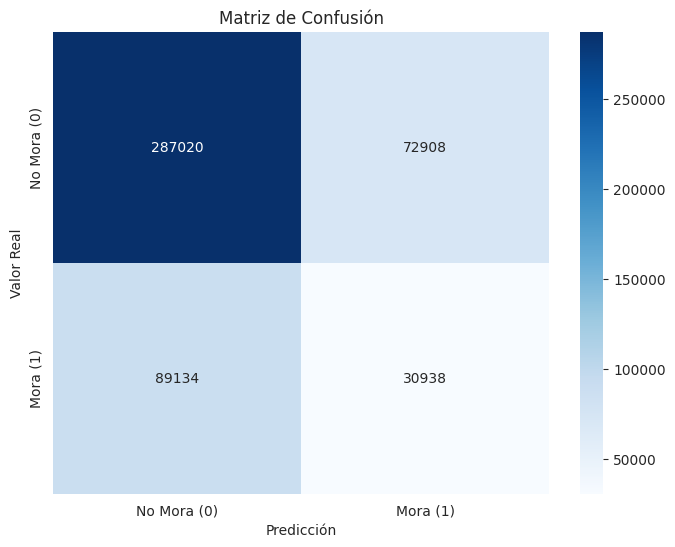

In [11]:
y_pred = model.predict(X_test)

print("--- Resultados de la Evaluación ---")
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Visualización de la Matriz de Confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Mora (0)', 'Mora (1)'], yticklabels=['No Mora (0)', 'Mora (1)'])
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión')
plt.show()

**Interpretación de las Métricas:**
* **Accuracy:** Proporción de predicciones correctas. Puede ser engañosa si las clases están desbalanceadas.
* **Classification Report:**
    * **Precision (Precisión):** De todas las predicciones para una clase, ¿cuántas fueron correctas? (TP / (TP + FP)). Importante si el costo de un Falso Positivo es alto.
    * **Recall (Sensibilidad):** De todos los casos reales de una clase, ¿cuántos se identificaron correctamente? (TP / (TP + FN)). Importante si el costo de un Falso Negativo es alto (e.g., no detectar una factura que entrará en mora).
    * **F1-score:** Media armónica de Precision y Recall. Buen indicador general del rendimiento, especialmente con clases desbalanceadas.
    * **Support:** Número de instancias reales de cada clase.
* **Confusion Matrix (Matriz de Confusión):**
    * **Verdaderos Negativos (TN):** Casos 'No Mora' predichos correctamente como 'No Mora'.
    * **Falsos Positivos (FP):** Casos 'No Mora' predichos incorrectamente como 'Mora' (Error Tipo I).
    * **Falsos Negativos (FN):** Casos 'Mora' predichos incorrectamente como 'No Mora' (Error Tipo II).
    * **Verdaderos Positivos (TP):** Casos 'Mora' predichos correctamente como 'Mora'.

## 8. Importancia de las Características

Random Forest nos permite ver qué características fueron más influyentes en la predicción.

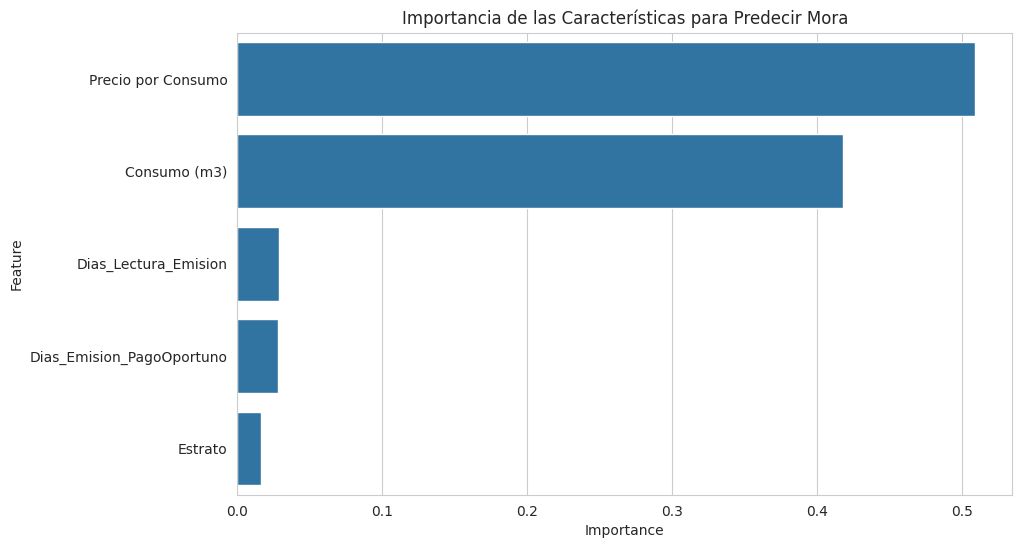

                     Feature  Importance
2         Precio por Consumo    0.509303
0               Consumo (m3)    0.417888
4       Dias_Lectura_Emision    0.028493
3  Dias_Emision_PagoOportuno    0.028252
1                    Estrato    0.016063


In [12]:
importances = model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Importancia de las Características para Predecir Mora')
plt.show()

print(feature_importance_df)

**Interpretación de la Importancia de Características:**
Esto nos muestra qué factores considera el modelo como los más decisivos para determinar si una factura entrará en mora. Puede guiar decisiones de negocio o refinamientos futuros del modelo.

## 9. Discusión de Resultados y Próximos Pasos

**Preguntas para la discusión:**
* ¿Es bueno el accuracy? ¿Cómo son precision/recall para la clase 'Mora=1'? ¿Qué características son las más importantes?
* El modelo (Random Forest) es bueno, regular o malo? para predecir la mora bajo las condiciones actuales y con las características seleccionadas.
* Es crucial recordar que se evitó el data leakage al no incluir `Dias_PagoOportuno_PagoReal`.

**Limitaciones y Consideraciones:**
* **Calidad de los datos:** El rendimiento del modelo depende de la calidad y representatividad de los datos de entrada.
* **Ingeniería de características:** Podrían explorarse más características (e.g., historial de pago del cliente, variaciones en el consumo, etc.).
* **Balance de clases:** Si la clase 'Mora=1' es minoritaria, el accuracy puede no ser la mejor métrica. F1-score, recall para la clase minoritaria, o AUC-ROC (no calculado aquí) son más informativos.
* **Simplificación:** Se usó una estrategia simple de manejo de NaNs. Métodos más sofisticados podrían ser necesarios.

**Próximos Pasos Potenciales:**
* **Optimización de Hiperparámetros:** Usar técnicas como GridSearchCV o RandomizedSearchCV para encontrar la mejor combinación de hiperparámetros para el RandomForest.
* **Probar otros modelos:** Evaluar otros algoritmos (e.g., Logistic Regression, Gradient Boosting, SVM).
* **Ingeniería de Características Avanzada:** Crear variables más complejas o basadas en el dominio del problema.
* **Análisis de Errores:** Investigar los casos donde el modelo se equivoca (Falsos Positivos y Falsos Negativos) para entender sus debilidades.
* **Puesta en Producción:** Si el modelo es satisfactorio, planificar cómo se integraría en un sistema para hacer predicciones sobre nuevas facturas.

Este tutorial proporciona una base para la predicción de mora. El modelado es un proceso iterativo de experimentación y mejora.